# HW 2 Solutions

In [1]:
import rebound
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import IFrame

## 1. Let's not be strangers!

For this problem we will work with the N-body code Rebound: https://rebound.readthedocs.io/en/latest/index.html. This has the advantage of having implementations in both C and Python. Note the Python version works as a wrapper for the C code, so the functions aren't completely doubly implemented, e.g., digging into the details of the integrators code requires opening the C code.

Before running any problems, let's first get to know this code and how it works (happily, this is relatively clean code and fairly straight-forward to parse).

### 1a.  Look through the documentation and poke around in the code.

Let's suppose we want to integrate the orbits for a 3 body system. Draw a flow chart for how the code initializes and evolves this interaction.

Here we can use the 3-body example evolving the 67P comet: https://rebound.readthedocs.io/en/latest/ipython_examples/Churyumov-Gerasimenko/

In [2]:
IFrame("./3body.001.png", width=1000, height=500)

### 1b.  The code offers a variety of different choices of integrators. 
Make a table of the different options, list their order of accuracy (if documented), what problems they are best suited for, and note any tunable parameters.  


The list of different integrators and a description can be found here: 
https://rebound.readthedocs.io/en/latest/integrators/#leapfrog

### Table of Inegrators

| Name | Accuracy | Strengths | Parameters |
| :- | :-: | :-: | :-: |
| IAS15| 15th | Most accurate and general, adaptive timestepping | epsilon (order of accuracy; -> 0 = const timestep), min_dt (minimum timestep), epsilon_global |
| WHFast| $\epsilon dt^p$ where $\epsilon=m_2/m_1$ | Best for dominant central object + small deviations from Keplerian | dt (timestep), corrector (related to order of accuracy), kernel (related to force calculation, coordinates, recalculate_coordinates_this_timestep, safe_mode, keep_unsynchronized |
| Gragg-Bulirsch-Stoer (BS)| medium accuracy / $\epsilon_{abs}+\epsilon_{rel} |y|$| Adapative timestepping and order of accuracy (an input) | min_dt, max_dt, eps_rel, eps_abs |
|Mercurius| variable (up to 15th) / $\epsilon_{abs}+\epsilon_{rel}|y|$| Hybrid HWFast (fast integration) + IAS15 (close encounters) | hillfac (related to Hill radius of particles), recalculate_coordinates_this_timestep, recalculate_dcrit_this_timestep, safe_mode |
|SABA | variable ($\epsilon dt^{10}+\epsilon^2 dt^{6}+\epsilon^3 dt^{4}$) | General high-order integrator |  safe_mode, keep_unsynchronized |
|JANUS | variable ($\epsilon dt^{10}+\epsilon^2 dt^{6}+\epsilon^3 dt^{4}$) | Bit-wise time-reversible high-order symplectic integrator, i.e., it is fast and accurate, acheived by scaling the variables to integer values  |  scale_pos, scale_vel, order, recalculate_integer_coordinates |
|EOS | variable (2, 4, 6, or 8) |Operator split integrator (flexible)  |  phi0 (outer operator splitting), phi1 (inner operating splitting, n (# of sub timesteps), safe_mode  |
|Leapfrog |2 | Fast and simple  | dt |
|SEI |2nd order to machine precision (no perturbing forces) or $\epsilon dt^3$ (external forces) | Fast and accurate for epicyclic problems  | Omega (orbital frequency), Omegaz (orbital frequency in z dir)  |
|Leapfrog | NA | Just update without moving particles  |  |


### 1c. Look at the leapfrog and symplectic epicyclic integrator code 
(see the repository src source directory). Make a flow chart for how these functions work. For production research you would want to read the method papers for each of the solvers to better understand their implementations, strengths and weaknesses. Here, this is not necessary unless you want to dig deeper into how the algorithms work.

The leapfrog method applied to N-body problems uses a 'drift-kick-drift' approach, where the particle positions are updated to time $t= t+ dt/2$, the velocities are updated and then the positions are updated by $dt/2$ again, completing the timestep.

In [3]:
IFrame("./leapfrog.001.png", width=1000, height=500)

Symplectic Epicycle Integrators work by integrating the Hamiltonian of the system (i.e., the problem is solved in terms of energy). This approach is exact for a 2-body problem. Figuring out exactly what is going on in this code physically requires following the citation to Rein & Tremaine 2011. We find that they are motivated by studying the particle dynamics within a disk (which can be modeled as a "shearing box": local force update + a velocity shear from the disk.)  "The shearing sheet is a model dynamical system that is used to study the small-scale dynamics of astrophysical discs. Numerical simulations of particle trajectories in the shearing sheet usually employ the leapfrog integrator, but this integrator performs poorly because of velocity-dependent (Coriolis) forces." They state that the SEI integrator is well-suited for disks in which the typical interparticle separation is large compared to the particles' Hill radii (e.g., as in planetary rings).

In [4]:
IFrame("./SEI_integrator.001.png", width=1000, height=500)

In [5]:
IFrame("./SEI_integrator.002.png", width=1000, height=500)

# 2 Hello Comets

You may recall seeing articles about the ESA Rosetta mission that visited and then sent a probe to land on a comet. This was eponymously named 67P/Churyumov–Gerasimenko comet (see \url{https://en.wikipedia.org/wiki/67P/Churyumov–Gerasimenko}). There is an example problem based on this comet, which we will use to get familiar with Rebound. 

## 2a. Set up and run the 67P/C-G example problem following the documentation 

Searching NASA Horizons for 'Sun'... Found: Target body name: Sun (10).
Searching NASA Horizons for 'Jupiter'... Found: Target body name: Jupiter Barycenter (5).
Searching NASA Horizons for 'Saturn'... Found: Target body name: Saturn Barycenter (6).
Searching NASA Horizons for 'NAME=Churyumov-Gerasimenko; CAP'... Found: Target body name: 67P/Churyumov-Gerasimenko.


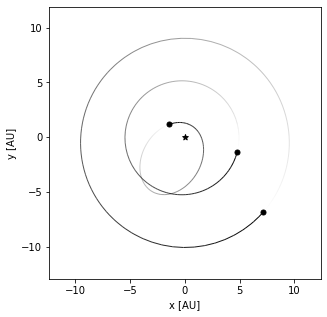

In [6]:
# We will just follow along with the documenation:

# Build the Solar System
sim = rebound.Simulation()
sim.add("Sun")
sim.add("Jupiter")
sim.add("Saturn")
sim.add("NAME=Churyumov-Gerasimenko; CAP", m=5.03e-18) #Get recent data from the NASA archive, add mass by hand

# Show instantaneous orbits of initial conditions
%matplotlib inline
fig = rebound.OrbitPlot(sim, unitlabel="[AU]")

<Figure size 432x288 with 0 Axes>

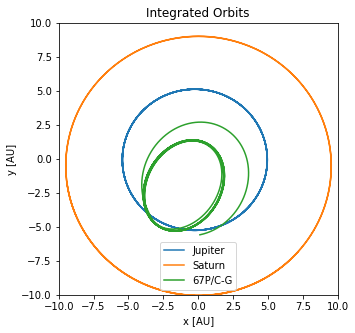

<Figure size 432x288 with 0 Axes>

In [7]:
# Initialize variables for storing and plotting; use fiducial settings
Noutputs = 10000
year = 2.*np.pi # One year in units where G=1
times = np.linspace(0.,-70.*year, Noutputs)
x = np.zeros((3,Noutputs)) # Store all two planets + comet for plotting
y = np.zeros((3,Noutputs))
z = np.zeros((3,Noutputs))

sim.integrator = "ias15" # IAS15 is the default integrator, so we actually don't need this line
sim.move_to_com()        # We always move to the center of momentum frame before an integration
sim.dt = -0.01           # Set timestep (go backwards)
ps = sim.particles       # ps is now an array of pointers and will change as the simulation runs

energy = sim.calculate_energy()   #Save the energy and angular momentum for later comparison
Lx, Ly, Lz = sim.calculate_angular_momentum()

for i,time in enumerate(times):
    sim.integrate(time)
    x[0][i] = ps[1].x   # This stores the data which allows us to plot it later
    y[0][i] = ps[1].y
    z[0][i] = ps[1].z
    x[1][i] = ps[2].x
    y[1][i] = ps[2].y
    z[1][i] = ps[2].z
    x[2][i] = ps[3].x
    y[2][i] = ps[3].y
    z[2][i] = ps[3].z
    
    
fig = plt.figure(figsize=(5,5))
ax = plt.subplot(111)
ax.set_xlim([-10,10])
ax.set_ylim([-10,10])
plt.plot(x[0], y[0],label="Jupiter")
plt.plot(x[1], y[1],label="Saturn")
plt.plot(x[2], y[2],label="67P/C-G")
plt.legend()
plt.title('Integrated Orbits')
plt.xlabel('x [AU]')
plt.ylabel('y [AU]')
plt.figure()

## 2b. Experiment with the integrator

Searching NASA Horizons for 'Sun'... Found: Target body name: Sun (10).
Searching NASA Horizons for 'Jupiter'... Found: Target body name: Jupiter Barycenter (5).
Searching NASA Horizons for 'Saturn'... Found: Target body name: Saturn Barycenter (6).
Searching NASA Horizons for 'NAME=Churyumov-Gerasimenko; CAP'... Found: Target body name: 67P/Churyumov-Gerasimenko.


<Figure size 432x288 with 0 Axes>

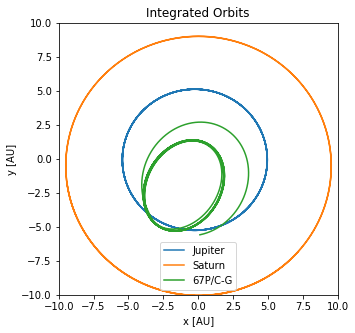

<Figure size 432x288 with 0 Axes>

In [8]:
# Built the Solar System
sim = rebound.Simulation()
sim.add("Sun")
sim.add("Jupiter")
sim.add("Saturn")
sim.add("NAME=Churyumov-Gerasimenko; CAP", m=5.03e-18) #Get recent data from the NASA archive, add mass by hand

# Initialize variables for storing and plotting
Noutputs = 10000
year = 2.*np.pi # One year in units where G=1
times = np.linspace(0.,-70.*year, Noutputs)
xint = np.zeros((3,Noutputs)) # Store all two planets + comet for plotting
yint = np.zeros((3,Noutputs))
zint = np.zeros((3,Noutputs))

sim.integrator = "whfast" #Let's try WHFast, which is supposed to be good for systems with a dominant obj.
#sim.integrator = "saba"
#sim.ri_saba.type = "(10,6,4)"
sim.move_to_com()        # We always move to the center of momentum frame before an integration
sim.dt = -0.01           # Set timestep (go backwards)
ps = sim.particles       # ps is now an array of pointers and will change as the simulation runs

energy = sim.calculate_energy()   #Save the energy and angular momentum for later comparison
Lx, Ly, Lz = sim.calculate_angular_momentum()

for i,time in enumerate(times):
    sim.integrate(time)
    xint[0][i] = ps[1].x   # This stores the data which allows us to plot it later
    yint[0][i] = ps[1].y
    zint[0][i] = ps[1].z
    xint[1][i] = ps[2].x
    yint[1][i] = ps[2].y
    zint[1][i] = ps[2].z
    xint[2][i] = ps[3].x
    yint[2][i] = ps[3].y
    zint[2][i] = ps[3].z
        
fig = plt.figure(figsize=(5,5))
ax = plt.subplot(111)
ax.set_xlim([-10,10])
ax.set_ylim([-10,10])
plt.plot(x[0], y[0],label="Jupiter")
plt.plot(x[1], y[1],label="Saturn")
plt.plot(x[2], y[2],label="67P/C-G")
plt.legend()
plt.title('Integrated Orbits')
plt.xlabel('x [AU]')
plt.ylabel('y [AU]')
plt.figure()

Mean relative error (Jupiter) =  2.5594904449822203e-11 -1.1010686461922003e-10
Mean relative error (Saturn) =  -1.0718883644452526e-11 4.831242310900267e-11
Mean relative error (67P/C-G) =  2.044621322463497e-05 -1.4811469001258585e-05


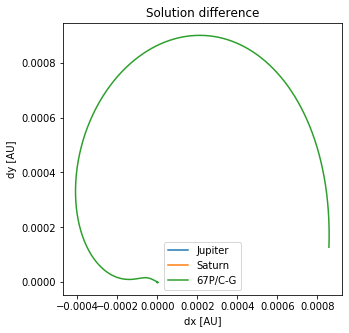

<Figure size 432x288 with 0 Axes>

In [9]:
# By eye it looks pretty similar! Let's take a look at the differences:

fig = plt.figure(figsize=(5,5))
ax = plt.subplot(111)
plt.plot((x[0]-xint[0]), y[0]-yint[0],label="Jupiter")
plt.plot(x[1]-xint[1], y[1]-yint[1],label="Saturn")
plt.plot(x[2]-xint[2], y[2]-yint[2],label="67P/C-G")
plt.legend()
plt.title('Solution difference')
plt.xlabel('dx [AU]')
plt.ylabel('dy [AU]')
plt.figure()

print("Mean relative error (Jupiter) = ", np.mean(np.abs(x[0]-xint[0])/x[0]), np.mean(np.abs(y[0]-yint[0])/y[0]))
print("Mean relative error (Saturn) = ", np.mean(np.abs(x[1]-xint[1])/x[1]), np.mean(np.abs(y[1]-yint[1])/y[1]))
print("Mean relative error (67P/C-G) = ", np.mean(np.abs(x[2]-xint[2])/x[2]), np.mean(np.abs(y[2]-yint[2])/y[2]))

The evolution of the small bodies is much more sensitive to the choice of integrator than the large body. For WHFast, the % error between the integrators is 6e-3% versus 2e-9%. It is clear from the figure that the errors also increase with time, so problems requiring a long time-history will need more accurate integrators! 

But which integrator is best? The documentation suggests WHFast is best for problems with a dominant central body (like our solar system problem); however, it may not be best is there are close encounters. Choosing the Mecurius integrator (which switches between WHFast and IAS15) should give the optimal result between IAS15 and WHFast. SABA produces results very similar (within 10e-9%) to IAS15; as above though, the difference for 67P/C-G grows more quickly than those for Jupiter and Saturn.

Some of the other integrators are not available in Python. The Leapfrog one would be interesting to compare in C, given that it is a much lower order of accuracy (2nd) and simpler compared to the others. The results should diverge pretty quickly!


## 2b. Experiment with the timestep

Searching NASA Horizons for 'Sun'... Found: Target body name: Sun (10).
Searching NASA Horizons for 'Jupiter'... Found: Target body name: Jupiter Barycenter (5).
Searching NASA Horizons for 'Saturn'... Found: Target body name: Saturn Barycenter (6).
Searching NASA Horizons for 'NAME=Churyumov-Gerasimenko; CAP'... Found: Target body name: 67P/Churyumov-Gerasimenko.


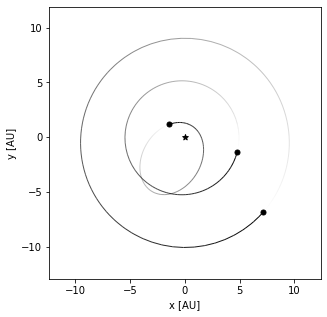

In [10]:
# Build the Solar System
sim = rebound.Simulation()
sim.add("Sun")
sim.add("Jupiter")
sim.add("Saturn")
sim.add("NAME=Churyumov-Gerasimenko; CAP", m=5.03e-18) #Get recent data from the NASA archive, add mass by hand

# Show instantaneous orbits of initial conditions
%matplotlib inline
fig = rebound.OrbitPlot(sim, unitlabel="[AU]")

In [11]:
# Initialize variables for storing and plotting; use fiducial settings
Noutputs = 10000
year = 2.*np.pi # One year in units where G=1
times = np.linspace(0.,-70.*year, Noutputs)
xt = np.zeros((3,Noutputs)) # Store all two planets + comet for plotting
yt = np.zeros((3,Noutputs))
zt = np.zeros((3,Noutputs))

# Let's iterate over several timesteps and save the errors
liste = []
listang = []
listjuperrx = []
listcomerrx = []

timesteps = [100, 10, 1, 0.5, 0.1, 0.05, 0.01, 0.005, 0.001]

for dt in timesteps:
    sim.integrator = "whfast" # 'ias15' 'whfast'
    sim.ri_ias15.min_dt = dt  #IAS15 has adaptive timestepping: to change dt you must change the min. allowed.
    sim.dt = dt              # Set timestep
    sim.move_to_com()        # We always move to the center of momentum frame before an integration
    sim.dt = dt              # Set timestep (go backwards)
    sim.ri_ias15.min_dt = dt
    ps = sim.particles       # ps is now an array of pointers and will change as the simulation runs

    energy = sim.calculate_energy()   #Save the energy and angular momentum for later comparison
    Lx, Ly, Lz = sim.calculate_angular_momentum()

    for i,time in enumerate(times):
        sim.integrate(time)
        xt[0][i] = ps[1].x   # This stores the data which allows us to plot it later
        yt[0][i] = ps[1].y
        zt[0][i] = ps[1].z
        xt[1][i] = ps[2].x
        yt[1][i] = ps[2].y
        zt[1][i] = ps[2].z
        xt[2][i] = ps[3].x
        yt[2][i] = ps[3].y
        zt[2][i] = ps[3].z
    
    liste.append(energy)
    listang.append(Lx)
    listjuperrx.append(np.mean(np.abs(x[0][9999]-xt[0][9999])/xt[0][9999]))
    listcomerrx.append(np.mean(np.abs(x[2][9999]-xt[2][9999])/xt[2][9999]))


<Figure size 432x288 with 0 Axes>

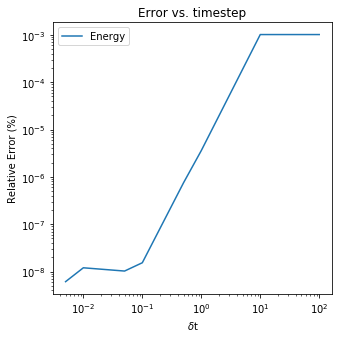

<Figure size 432x288 with 0 Axes>

In [12]:
# Calculate relative Error
engerr = np.abs((np.array(liste)-liste[8])/liste[8]*100)
angerr = (np.array(listang)-listang[8])/listang[8]*100

fig = plt.figure(figsize=(5,5))
ax = plt.subplot(111)
plt.loglog(np.abs(timesteps[:-1]), engerr[:-1],label="Energy")
plt.legend()
plt.title('Error vs. timestep')
plt.xlabel('$\delta$t')
plt.ylabel('Relative Error (%)')
plt.figure()


Both IAS15 and WHFast show sharp decrease in the accuracy of energy conservation for increasing dt. Below a timestep of 0.01, the accuracy doesn't increase further, likely in part due to roundoff error/numerics of solving the problem.

## 2c. How does the result change when you add the rest of the solar system planets? Which is the larger source of error -- the parameter choices or missing bodies? 

Searching NASA Horizons for 'Sun'... Found: Target body name: Sun (10).
Searching NASA Horizons for 'Mercury'... Found: Target body name: Mercury Barycenter (199).
Searching NASA Horizons for 'Venus'... Found: Target body name: Venus Barycenter (299).
Searching NASA Horizons for 'Earth'... Found: Target body name: Earth-Moon Barycenter (3).
Searching NASA Horizons for 'Mars'... Found: Target body name: Mars Barycenter (4).
Searching NASA Horizons for 'Jupiter'... Found: Target body name: Jupiter Barycenter (5).
Searching NASA Horizons for 'Saturn'... Found: Target body name: Saturn Barycenter (6).
Searching NASA Horizons for 'Neptune'... Found: Target body name: Neptune Barycenter (8).
Searching NASA Horizons for 'Uranus'... Found: Target body name: Uranus Barycenter (7).
Searching NASA Horizons for 'NAME=Churyumov-Gerasimenko; CAP'... Found: Target body name: 67P/Churyumov-Gerasimenko.


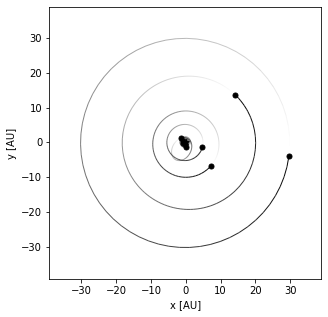

In [13]:
 # Build the Solar System
sim = rebound.Simulation()
sim.add("Sun")
sim.add("Mercury")
sim.add("Venus")
sim.add("Earth")
sim.add("Mars")
sim.add("Jupiter")
sim.add("Saturn")
sim.add("Neptune")
sim.add("Uranus")
sim.add("NAME=Churyumov-Gerasimenko; CAP", m=5.03e-18) #Get recent data from the NASA archive, add mass by hand

# Show instantaneous orbits of initial conditions
%matplotlib inline
fig = rebound.OrbitPlot(sim, unitlabel="[AU]")

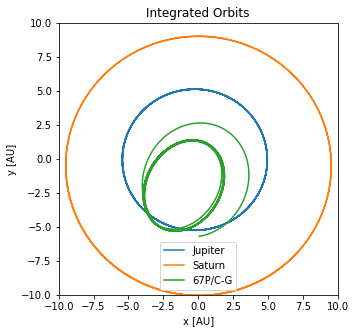

Mean relative difference (Jupiter) =  0.00017019352058185731 -0.001424444428873837
Mean relative difference (Saturn) =  0.00012750388485750704 7.982662397036297e-05
Mean relative difference (67P/C-G) =  -0.006164979363578978 0.00023768648507088876


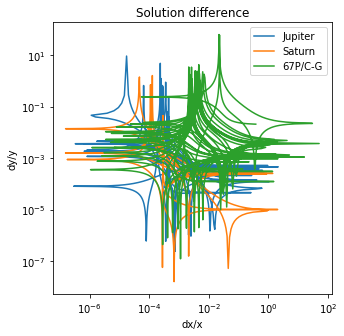

/Users/so8266/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:59: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.


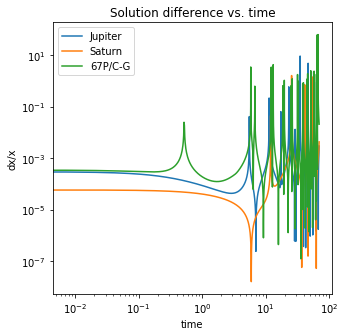

In [14]:
# Initialize variables for storing and plotting
Noutputs = 10000
year = 2.*np.pi # One year in units where G=1
times = np.linspace(0.,-70.*year, Noutputs)
xall = np.zeros((3,Noutputs)) # Store Jupiter and Saturn  + comet for plotting
yall = np.zeros((3,Noutputs))
zall = np.zeros((3,Noutputs))

sim.integrator = "ias15" 
sim.move_to_com()        # We always move to the center of momentum frame before an integration
sim.dt = -0.01           # Set timestep (go backwards)
ps = sim.particles       # ps is now an array of pointers and will change as the simulation runs

energy = sim.calculate_energy()   #Save the energy and angular momentum for later comparison
Lx, Ly, Lz = sim.calculate_angular_momentum()

for i,time in enumerate(times):
    sim.integrate(time)
    xall[0][i] = ps[5].x   # This stores the data which allows us to plot it later
    yall[0][i] = ps[5].y
    zall[0][i] = ps[5].z
    xall[1][i] = ps[6].x
    yall[1][i] = ps[6].y
    zall[1][i] = ps[6].z
    xall[2][i] = ps[9].x
    yall[2][i] = ps[9].y
    zall[2][i] = ps[9].z
        
fig = plt.figure(figsize=(5,5))
ax = plt.subplot(111)
ax.set_xlim([-10,10])
ax.set_ylim([-10,10])
plt.plot(xall[0], yall[0],label="Jupiter")
plt.plot(xall[1], yall[1],label="Saturn")
plt.plot(xall[2], yall[2],label="67P/C-G")
plt.legend()
plt.title('Integrated Orbits')
plt.xlabel('x [AU]')
plt.ylabel('y [AU]')
plt.show()

#Compare with original
print("Mean relative difference (Jupiter) = ", np.mean(np.abs(x[0]-xall[0])/x[0]), np.mean(np.abs(y[0]-yall[0])/y[0]))
print("Mean relative difference (Saturn) = ", np.mean(np.abs(x[1]-xall[1])/x[1]), np.mean(np.abs(y[1]-yall[1])/y[1]))
print("Mean relative difference (67P/C-G) = ", np.mean(np.abs(x[2]-xall[2])/x[2]), np.mean(np.abs(y[2]-yall[2])/y[2]))

fig = plt.figure(figsize=(5,5))
ax = plt.subplot(111)
plt.loglog(np.abs((x[0]-xall[0])/x[0]), np.abs((y[0]-yall[0])/y[0]),label="Jupiter")
plt.loglog(np.abs((x[1]-xall[1])/x[1]), np.abs((y[1]-yall[1])/y[1]),label="Saturn")
plt.loglog(np.abs((x[2]-xall[2])/x[2]), np.abs((y[2]-yall[2])/y[2]),label="67P/C-G")
plt.legend()
plt.title('Solution difference')
plt.xlabel('dx/x')
plt.ylabel('dy/y')
plt.show()


time = np.linspace(0,70,1e4)
fig = plt.figure(figsize=(5,5))
ax = plt.subplot(111)
plt.loglog(time, np.abs((y[0]-yall[0])/y[0]),label="Jupiter")
plt.loglog(time, np.abs((y[1]-yall[1])/y[1]),label="Saturn")
plt.loglog(time, np.abs((y[2]-yall[2])/y[2]),label="67P/C-G")
plt.legend()
plt.title('Solution difference vs. time')
plt.xlabel('time')
plt.ylabel('dx/x')
plt.show()

Including the planets has a large effect over long time scales (e.g., more than a year). When the body does multiple orbits, like 67P, the error approaches 100%, since the orbit diverges almost completely from the initial solution. It is clear that, given reasonable timesteps and integrator, the number of bodies and their gravitational interactions dominates the error!

 # 3. Finding Planet X (actually Planet Nine)

Searching NASA Horizons for 'Sun'... Found: Target body name: Sun (10).
Searching NASA Horizons for 'Mercury'... Found: Target body name: Mercury Barycenter (199).
Searching NASA Horizons for 'Venus'... Found: Target body name: Venus Barycenter (299).
Searching NASA Horizons for 'Earth'... Found: Target body name: Earth-Moon Barycenter (3).
Searching NASA Horizons for 'Mars'... Found: Target body name: Mars Barycenter (4).
Searching NASA Horizons for 'Jupiter'... Found: Target body name: Jupiter Barycenter (5).
Searching NASA Horizons for 'Saturn'... Found: Target body name: Saturn Barycenter (6).
Searching NASA Horizons for 'Neptune'... Found: Target body name: Neptune Barycenter (8).
Searching NASA Horizons for 'Uranus'... Found: Target body name: Uranus Barycenter (7).
Searching NASA Horizons for 'Pluto'... Found: Target body name: Pluto Barycenter (9).
Searching NASA Horizons for 'Sedna'... Found: Target body name: 90377 Sedna (2003 VB12).


/Users/so8266/anaconda3/lib/python3.7/site-packages/rebound/horizons.py:149: RuntimeWarning: Warning: Mass cannot be retrieved from NASA HORIZONS. Set to 0.
  warnings.warn("Warning: Mass cannot be retrieved from NASA HORIZONS. Set to 0.", RuntimeWarning)


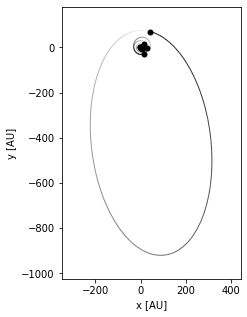

In [15]:
# Build the Solar System without Planet Nine (fiducial)
sim = rebound.Simulation()
sim.add("Sun")
sim.add("Mercury")
sim.add("Venus")
sim.add("Earth")
sim.add("Mars")
sim.add("Jupiter")
sim.add("Saturn")
sim.add("Neptune")
sim.add("Uranus")
sim.add("Pluto")
sim.add("Sedna") # Add Sedna for kicks

# Show instantaneous orbits of initial conditions
%matplotlib inline
fig = rebound.OrbitPlot(sim, unitlabel="[AU]")

In [16]:
# Initialize variables for storing and plotting
Noutputs = 10000
year = 2.*np.pi # One year in units where G=1
times = np.linspace(0.,10.*year, Noutputs)
x8 = np.zeros((3,Noutputs)) # Store Jupiter and Saturn  + comet for plotting
y8 = np.zeros((3,Noutputs))
z8 = np.zeros((3,Noutputs))

sim.integrator = "mercurius" 
sim.N_active = sim.N
sim.move_to_com()        # We always move to the center of momentum frame before an integration
ps = sim.particles       # ps is now an array of pointers and will change as the simulation runs

for i,time in enumerate(times):
    sim.integrate(time)
    x8[0][i] = ps[5].x   # This stores the data which allows us to plot it later
    y8[0][i] = ps[5].y
    z8[0][i] = ps[5].z
    x8[1][i] = ps[9].x  #Pluto
    y8[1][i] = ps[9].y
    z8[1][i] = ps[9].z
    x8[2][i] = ps[10].x #Sedna
    y8[2][i] = ps[10].y
    z8[2][i] = ps[10].z

Searching NASA Horizons for 'Sun'... Found: Target body name: Sun (10).
Searching NASA Horizons for 'Mercury'... Found: Target body name: Mercury Barycenter (199).
Searching NASA Horizons for 'Venus'... Found: Target body name: Venus Barycenter (299).
Searching NASA Horizons for 'Earth'... Found: Target body name: Earth-Moon Barycenter (3).
Searching NASA Horizons for 'Mars'... Found: Target body name: Mars Barycenter (4).
Searching NASA Horizons for 'Jupiter'... Found: Target body name: Jupiter Barycenter (5).
Searching NASA Horizons for 'Saturn'... Found: Target body name: Saturn Barycenter (6).
Searching NASA Horizons for 'Neptune'... Found: Target body name: Neptune Barycenter (8).
Searching NASA Horizons for 'Uranus'... Found: Target body name: Uranus Barycenter (7).
Searching NASA Horizons for 'Pluto'... Found: Target body name: Pluto Barycenter (9).
Searching NASA Horizons for 'Sedna'... Found: Target body name: 90377 Sedna (2003 VB12).


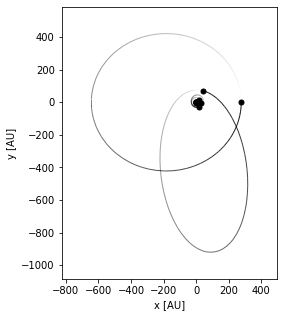

In [17]:
# Build the Solar System with Planet Nine
massnine = 3e-6 #In solar masses; Jupiter is 0.00096 Msun; Earth is 3e-6 Msun
radnine = 1e-5    # In au; Jupiter radius is 4.6e-4
enine = 0.4      # Eccentricity
anine = 460.     # Semi-major axis (au)

sim2 = rebound.Simulation()
sim2.add("Sun")
sim2.add("Mercury")
sim2.add("Venus")
sim2.add("Earth")
sim2.add("Mars")
sim2.add("Jupiter")
sim2.add("Saturn")
sim2.add("Neptune")
sim2.add("Uranus")
sim2.add("Pluto")
sim2.add("Sedna") #Get recent data from the NASA archive, add mass by hand
sim2.add(m=massnine,r=radnine,a=anine,e=enine) 

# Show instantaneous orbits of initial conditions
%matplotlib inline
fig = rebound.OrbitPlot(sim2, unitlabel="[AU]")

sim2.move_to_com()        # We always move to the center of momentum frame before an integration

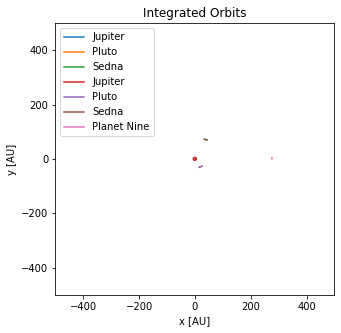


% difference at final position (Pluto) =  0.003306285263286902 4.979484551851138e-05 0.004675793460415492
% difference at final position (Sedna) =  0.002448758644024035 1.85881757636725e-05


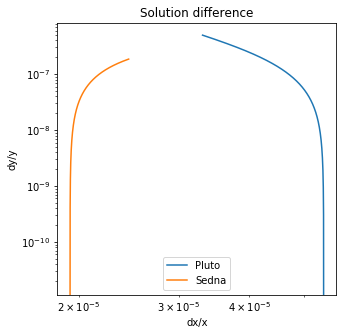

In [18]:
# Initialize variables for storing and plotting
Noutputs = 10000
year = 2.*np.pi # One year in units where G=1
times = np.linspace(0.,10.*year, Noutputs)
x9 = np.zeros((4,Noutputs)) # Store Jupiter and Saturn  + comet for plotting
y9 = np.zeros((4,Noutputs))
z9 = np.zeros((4,Noutputs))

sim2.integrator = "mercurius"
sim2.N_active = sim2.N
ps = sim2.particles       # ps is now an array of pointers and will change as the simulation runs

for i,time in enumerate(times):
    sim2.integrate(time) # Note everytime this is called it will iterate another "time" further
    x9[0][i] = ps[5].x   # This stores the data which allows us to plot it later
    y9[0][i] = ps[5].y
    z9[0][i] = ps[5].z
    x9[1][i] = ps[9].x
    y9[1][i] = ps[9].y
    z9[1][i] = ps[9].z
    x9[2][i] = ps[10].x
    y9[2][i] = ps[10].y
    z9[2][i] = ps[10].z
    x9[3][i] = ps[11].x
    y9[3][i] = ps[11].y
    z9[3][i] = ps[11].z
        
fig = plt.figure(figsize=(5,5))
ax = plt.subplot(111)
ax.set_xlim([-500,500])
ax.set_ylim([-500,500])
plt.plot(x8[0], y8[0],label="Jupiter")
plt.plot(x8[1], y8[1],label="Pluto")
plt.plot(x8[2], y8[2],label="Sedna")
plt.plot(x9[0], y9[0],label="Jupiter")
plt.plot(x9[1], y9[1],label="Pluto")
plt.plot(x9[2], y9[2],label="Sedna")
plt.plot(x9[3], y9[3],label="Planet Nine")
plt.legend(loc='upper left')
plt.title('Integrated Orbits')
plt.xlabel('x [AU]')
plt.ylabel('y [AU]')
plt.show()

#Compare with original in %
pxlast = np.abs((x9[1][-1] - x8[1][-1])/x8[1][-1])*100
pylast = np.abs((y9[1][-1] - y8[1][-1])/y8[1][-1])*100
pzlast = np.abs((z9[1][-1] - z8[1][-1])/y8[1][-1])*100
sxlast = np.abs((x9[2][-1] - x8[2][-1])/x8[2][-1])*100
sylast = np.abs((y9[2][-1] - y8[2][-1])/y8[2][-1])*100
print()
print("% difference at final position (Pluto) = ", pxlast, pylast, (pxlast**2 + pxlast**2+ pzlast**2)**0.5 )
print("% difference at final position (Sedna) = ", sxlast, sylast)

fig = plt.figure(figsize=(5,5))
ax = plt.subplot(111)
#plt.loglog(np.abs((x[0]-xall[0])/x[0]), np.abs((y[0]-yall[0])/y[0]),label="Jupiter")
plt.loglog(np.abs((x9[1]-x8[1])/x8[1]), np.abs((y9[1]-y8[1])/y8[1]),label="Pluto")
plt.loglog(np.abs((x9[2]-x8[2])/x8[2]), np.abs((y9[2]-y8[2])/y8[2]),label="Sedna")
plt.legend()
plt.title('Solution difference')
plt.xlabel('dx/x')
plt.ylabel('dy/y')
plt.show()


#time = np.linspace(0,70,1e4)
#fig = plt.figure(figsize=(5,5))
#ax = plt.subplot(111)
#plt.loglog(time, np.abs((y[0]-yall[0])/y[0]),label="Jupiter")
#plt.loglog(time, np.abs((y[1]-yall[1])/y[1]),label="Saturn")
#plt.loglog(time, np.abs((y[2]-yall[2])/y[2]),label="67P/C-G")
#plt.legend()
#plt.title('Solution difference vs. time')
#plt.xlabel('time')
#plt.ylabel('dx/x')
#plt.show()

Adding a planet 1000 times Earth's mass (3e-3 Msun or ~3 MJ), gives a relative error of 5%. So planet X would need to be pretty large (e.g., 10 MJ) in order to affect Pluto's orbit by 10% over 10 years. 

This suggest that something the size of a gas-giant would be pretty noticable. However, any such planet X that was closer to Earth size would be much harder to detect given how far out it is (only affecting Pluto's orbit by 0.005% over 10 years). Its influence would also be obscured by all the other mass out there in the Kuiper Belt -- as we learned above the main influence on the orbits is (the addition of) other bodies rather than the timestep or integrator. 